# Optimizing for KL-divergence with Gurobi

Skeleton for debugging

In [1]:
import gurobipy as gp
from gurobipy import GRB
import tomllib as tml
import numpy as np
import display_helper as dh
from copy import deepcopy
from sys import stdout
import datetime
from builtins import open

In [2]:
# get gurobi credentials
options = tml.load(open("license.toml", "rb"))

# establish env (must close)
env = gp.Env(params=options)

# save to file indicator
SAVE_TO_FILE = True

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2527858
Academic license 2527858 - for non-commercial use only - registered to mb___@ur.rochester.edu


In [3]:
# establish model (must close)
model = gp.Model(env=env)

## Helper Functions

These are helper functions designed by Quan for generating and working within our problem space

In [4]:
# Functions for probability matrix
def normpdf(x: float, mean: float, std: float) -> float:
  var = float(std)**2
  denom = (2*np.pi*var)**.5
  num = np.exp(-(float(x)-float(mean))**2/(2*var))
  return num/denom


def highlow(ind):
  if ind == 0 or ind == 2:
    return 0.4
  else:
    return 0.2


def gen_state_prob(num_traits: int, num_states: int):
  mean = (num_states-1) / 2
  std = mean / 1.25

  state_prob = np.zeros(tuple([num_states] * num_traits), dtype=np.float64)
  for inds in np.ndindex(state_prob.shape):
    prob = 1
    for ind in inds:
      prob *= normpdf(ind, mean, std)
      # prob *= highlow(ind)
    
    state_prob[inds] = prob

  state_prob = state_prob / np.sum(state_prob)

  return state_prob.flatten()

# functions for reward matrix
def unnumerize(num_traits: int, num_states: int, action: int):
  ufaction = []
  while action > 0:
    ufaction.insert(0, action % num_states)
    action = action // num_states

  while len(ufaction) < num_traits:
    ufaction.insert(0, 0)

  return ufaction


def reward_fn(param: tuple[float, float], state, action):
  
  l1dist = 0
  for s, a in zip(state, action):
    l1dist += abs(s - a)
          
  return param[0] - param[1] * l1dist


def reward_matrix(num_traits: int, num_states: int, reward_param: tuple[float, float]):
  total_states = num_states**num_traits
  res = np.array([[0 for _ in range(total_states)] for _ in range(total_states)], dtype=np.float64)
  for x in range(total_states):
    for y in range(total_states):
      s1 = unnumerize(num_traits, num_states, x)
      s2 = unnumerize(num_traits, num_states, y)

      res[x, y] = reward_fn(reward_param, s1, s2)

  return res

# generate neighbor list (graph connections)
def is_adj(num_traits: int, num_states: int, i: int, j: int):
  s1 = unnumerize(num_traits, num_states, i)
  s2 = unnumerize(num_traits, num_states, j)

  l1dist = 0
  for s, a in zip(s1, s2):
    l1dist += abs(s - a)

  return l1dist == 1

def neighbor_lst(num_traits: int, num_states: int):
  total_states = num_states**num_traits
  res = [[] for _ in range(total_states)]
  for x in range(total_states):
    for y in range(x, total_states):
      if is_adj(num_traits, num_states, x, y):
        res[x].append(y)
        res[y].append(x)

  return res

## Problem setup

I'm going to step through, adding variables and their related constraints as they become relevant.

In [5]:
# parameters
t = 3                   # number of traits (?) (cube is n,n,n)
n_per_t = 3             # number of expressions per trait  (?)
n = n_per_t**t          # size of state space
k = 6                   # number of signals
reward_param = (1, 0.5) # 1 - (0.5 * dist to correct)

V = np.asarray([i for i in range(n)])

state_prob = gen_state_prob(t, n_per_t)
# state_prob = np.full(n, 1/n, dtype=np.float64)

reward = reward_matrix(t, n_per_t, reward_param)

neighbor = neighbor_lst(t, n_per_t)

In [6]:
# output setup
if SAVE_TO_FILE:
    timestamp = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")
    distrobution = "gaussian" # informal tag only
    output_filename = f"{t}_{n_per_t}_{k}_{distrobution}_{timestamp}.txt"
    output_file = open(output_filename, "a")
    
    print(f"traits: {t}\texpressions: {n_per_t}\tstates: {n}\tsignals: {k}", file=output_file)
    print(f"reward: {reward_param[0]}, {reward_param[1]}", file=output_file)
else:
    output_file = stdout

### Hess Variables

X is the probability signal j is sent given state i.

X[i, j] = 1 iff state i is in bucket j

With just X, we can create a few simple rules:
* There are exactly K buckets
* A state can only belong to one bucket
* A state cannot belong to a non-existent bucket

In [7]:
x = model.addVars(V, V, vtype=GRB.BINARY, name="x")

model.update()

# /* there are exactly k buckets */
# kBucketConstr: sum{j in V} x[j, j] = k;
k_bucket = gp.quicksum( (x[j,j]) for j in V ) == k
model.addConstr(k_bucket)

# /* a state can only belong to one bucket */
# uniqueBucketConstr{i in V}: sum{j in V} x[i, j] = 1;
unique_bucket = ( gp.quicksum( (x[i,j]) for j in V ) == 1 for i in V )
model.addConstrs(unique_bucket)

# /* a state cannot belong to a non-existant bucket */
# nonexBucketConstr{i in V, j in V}: x[i, j] <= x[j, j];
nonex_bucket = ( (x[i,j] <= x[j,j]) for i in V for j in V )
model.addConstrs(nonex_bucket)

model.update()

X is only able to hold a 0 or a 1, so Quan introduced a mirror variable, CX, to do logarithms.

The desired behavior of CX is as follows:
```
cx[i, j] = 0                   if x[i, j] = x[j, j] = 0 (nonexistant bucket)
         = 1e-7                if x[i, j] = 0 and x[j, j] = 1 (states outside 
                               of bucket j)             
         = 1 - (k-1) * (1e-7)  if x[i, j] = x[j, j] = 1 (states in bucket j)
```

In [8]:
cx = model.addVars(V, V, vtype=GRB.CONTINUOUS)

model.update()

# converted x constraint
small_val_constr_1 = ( (cx[i, j] <= x[j, j] * (x[i, j] + 1e-7))  for i in V for j in V )
model.addConstrs(small_val_constr_1)

small_val_constr_2 = ( (cx[i, j] >= x[j, j] * (1e-7)) for i in V for j in V )
model.addConstrs(small_val_constr_2)

sum_cx_constr = ( (gp.quicksum( cx[i, j] for j in V ) == 1) for i in V )
model.addConstrs(sum_cx_constr)

model.update()

### Cut Edge + Flow

Y and F contain the variable for our Cut Edge and Flow constraints, as per the work from Buchannan.

Y[i, j] = 1 iff egge {i, j} is cut

F[i, j] = 1 iff state i flows to state j.

I'm combining these for clarity. I'm also not exactly sure what M is.

In [9]:
# cut egde variables
# y[i, j] = 1 iff edge {i, j} is cut
y = model.addVars(V, V, vtype=GRB.BINARY)

model.update()

# /* cut edge constraints */
# edge {i, j} is cut if i and j are not adjacent.
cut_edge_not_adj = ( y[i, j] == 1 for i in V for j in np.setdiff1d(V, np.array(neighbor[i])) )
model.addConstrs(cut_edge_not_adj)

# edge {i, j} is cut if i and j are in different buckets.
cut_edge_diff_bucket = ( y[i, j] >= x[i, l] - x[j, l] for i in V for j in V for l in V)
model.addConstrs(cut_edge_diff_bucket)

model.update()

In [10]:
# What does this mean?
M = n - k + 1

# flow variables
# f[i, j] = the flow from state i to state j
f = model.addVars(V, V)

model.update()

# do not send flow across cut edges
cut_edge_flow = ( f[i, j] + f[j, i] <= M * (1 - y[i, j]) for i in V for j in V )
model.addConstrs(cut_edge_flow)

# /* flow constraint */
# if not a root, consume some flow.
# if a root, only send out (so much) flow.
flow = ( gp.quicksum( f[j, i]- f[i, j] for j in neighbor[i] )
      >= 1 - M * x[i, i] for i in V )
model.addConstrs(flow)

model.update()

### KL-Divergence Calculation

Now, we need to get into the weeds of caclulating KL-divergence

Z - the probability of signal j AND state i. Essentially, X times state probability. If you sum z[i, j] over all i and all j, the sum is 1. Used to caculate probability - not relevant in uniform distrobutions.

z[i, j] = cx[i, j] * state_prob[i]

z[i, j] == pr[signal j | state i] * pr[state i] == pr[signal j, state i]

In [11]:
z = model.addVars(V, V, vtype=GRB.CONTINUOUS)

model.update()

# z constraint
z_constr = ( z[i, j] == cx[i, j] * state_prob[i] for i in V for j in V )
model.addConstrs(z_constr)

model.update()

W - 1 / probability of signal j

Quan says:

NOTE: Although w[j] = x[j, j] / sum(z[i, j] for i in V), gurobi does not allow dividing by a variable
```
w[i] =              0                if x[j, j] = 0 (nonexistant bucket)
     = 1 / sum( z[i, j] for i in V ) if x[j, j] = 1 (bucket j)
```
Generally:
w[i] == 1 / sum( pr[signal j, state i] for all i) == 1 / pr[signal j]




In [12]:
w = model.addVars(V, vtype=GRB.CONTINUOUS)

model.update()

w_constr = ( w[j] * gp.quicksum(z[i, j] for i in V) == x[j, j] for j in V )
#w_constr = ( w[j] * gp.quicksum(cx[i, j] for i in V) == x[j, j] for j in V )
model.addConstrs(w_constr)

# NOTE: To ensure that w[j] == 0 when x[j, j] == 0
w_zero = ( w[j] * x[j, j] == w[j] for j in V )
model.addConstrs(w_zero)

model.update()

Prob is z * w. I could use a better description of this one - my note taking in the meeting broke down a bit towards the second half.

prob[i, j] = z[i, j] * w[i]
```
prob[i, j] == pr[signal j, state i] * (1/pr[signal j]) 
           == pr[state i | signal j]
```

This is different than x (I get confused) which is pr[signal j | state i]

In uniform cases, cx = z so there are two versions of the constraint.

In [13]:
prob = model.addVars(V, V, vtype=GRB.CONTINUOUS)

model.update()

prob_constr = ( (prob[i, j] == z[i, j] * w[j]) for i in V for j in V )
# prob_constr = ( (prob[i, j] == cx[i, j] * w[j]) for i in V for j in V )
model.addConstrs(prob_constr)

model.update()

Probdiff takes what we just calculated and divides it by the state probability of state i. 

probdiff[i, j] = prob[i, j] / state_prob[i]

probdiff[i, j] == pr[state i | signal j] / pr[state i]

The upper bound for this variable is 27.

In [14]:
probdiff = model.addVars(V, V, ub=27, vtype=GRB.CONTINUOUS)

model.update()

probdiff_constr = ( (probdiff[i, j] == prob[i, j] / state_prob[i]) for i in V for j in V )
model.addConstrs(probdiff_constr)

model.update()

Calculating the average information content and payoff of all n results

CProbdiff works like CX, cleaning up probdiff for logirithmic work.

cprobdiff[i, j] = max(1, probdiff[i, j])

If probdiff[i, j] == 0, then cprobdiff[i, j] == 1 so that taking the log would result in log 1 = 0

Effectively, all values in cprobdiff are 1-27.

In [15]:
cprobdiff = model.addVars(V, V, ub=27, vtype=GRB.CONTINUOUS)

model.update()

cprobdiff_constr = ( (cprobdiff[i, j] == gp.max_(probdiff[i, j], constant=1)) for i in V for j in V )
model.addConstrs(cprobdiff_constr)

model.update()

Our final move is to add the log variables. 

log[i, j] = log(cprobdiff[i, j])

Generally, log[i, j] == log(pr[state i | signal j] / pr[state i])

In [16]:
log = model.addVars(V, V, vtype=GRB.CONTINUOUS)

model.update()

for i in V:
  for j in V:
    # log[i, j] = log(cprobdiff[i, j])
    model.addGenConstrLog(cprobdiff[i, j], log[i, j])

model.update()

kl will hold the inner multiplication of our *unweighted* KL-divergence. This is because Gurobi only allows us to relate two variables at a time, so the move to weighted KL-divergence requires an extra set of variables to achieve the desired objective function.

In [17]:
kl = model.addVars(V, V, vtype=GRB.CONTINUOUS)
model.update()

model.addConstrs(kl[i,j] == prob[i,j] * log[i,j] for i in V for j in V)
model.update()

W is 1 / signal_prob[j], or generally 1 / sum(z[:, j] for j in V). I'm just extracting the denominator from that earlier relation as our signal probability.

In [18]:
signal_prob = model.addVars(V, vtype=GRB.CONTINUOUS)
model.update()

model.addConstrs(signal_prob[j] == gp.quicksum(z[i,j] for i in V) for j in V)
model.update()

### Objective Function

In [19]:
# payoff with min cut edge
# NOTE: maximizing payoff takes priority over minimizing cut edges so the payoff is multiplied by a big number before subtracting the number of cut edges
# objective = gp.quicksum( gp.quicksum( (state_prob[i] * x[i,j] * reward[i][j]) for j in V) for i in V ) / n * (n**2 + 1) * 10000 - gp.quicksum( y[i, j] for i in V for j in V )

# Expected reward - payoff
# Note: I think we might have used GRB.MINIMIZE for this objective function... check the buchanan code
# objective = gp.quicksum( gp.quicksum( (state_prob[i] * x[i,j] * reward[i][j]) for j in V) for i in V ) / n

# maximize KL-Divergence
objective = gp.quicksum( signal_prob[j] * gp.quicksum( kl[i,j] for i in V ) for j in V)

model.setObjective(objective, GRB.MAXIMIZE)

## Results

Did we add one too many straws?

In [20]:
# params for multiple solutions:
model.Params.PoolSolutions = 1
model.Params.PoolSearchMode = 2

model.update()

# can we solve?
model.optimize()

Set parameter PoolSolutions to value 1
Set parameter PoolSearchMode to value 2
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 2600X Six-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2527858 - for non-commercial use only - registered to mb___@ur.rochester.edu
Optimize a model with 24058 rows, 7344 columns and 68634 nonzeros
Model fingerprint: 0x32357332
Model has 729 quadratic objective terms
Model has 2241 quadratic constraints
Model has 1458 general constraints
Variable types: 5886 continuous, 1458 integer (1458 binary)
Coefficient statistics:
  Matrix range     [1e-07, 7e+01]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e-07, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]
  GenCon const rng [1e+00, 1e+00]
Presolve added 0 row

In [21]:
centers = [j for j in V if round(x[j,j].getAttr("x")) == 1]
bucket_lookup = dict()

for ind, j in enumerate(centers):
    print(f"Bucket {j+1}: ", end="", file=output_file)
    members = [i for i in V if round(x[i,j].getAttr("x")) == 1]
    for i in members:
        print(f"{i+1} ", end="", file=output_file)
        bucket_lookup[i] = ind
    print(file=output_file)

### Display

Showing the cube

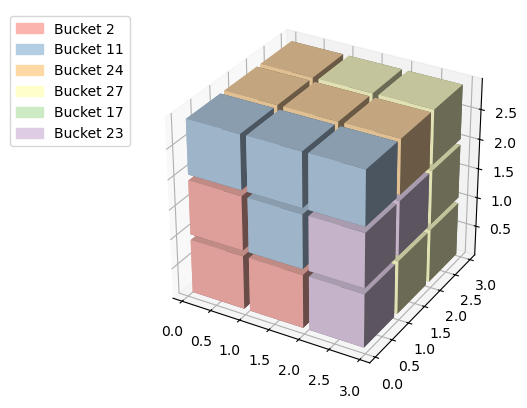

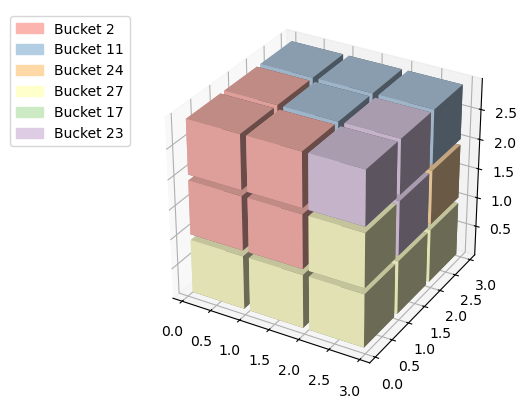

In [22]:
og_cube, legend = dh.cube_from_lookup(bucket_lookup, t, centers)
dh.show(og_cube, legend)

cube = deepcopy(og_cube)

cube = dh.rotate_aboutX(cube)
dh.show(cube, legend)

Can be rotated ad infinitum:

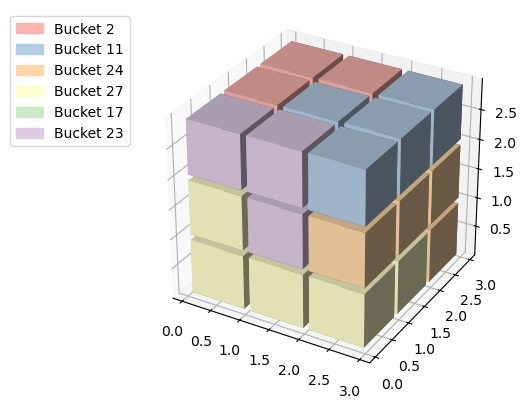

In [23]:
cube = dh.rotate_aboutZ(cube)
dh.show(cube, legend)

### Information Measure

Convert strategy to calculate information content measure.

In [24]:
def convert(num_traits, num_states, num_signals, strat):
  total_states = num_states**num_traits
  small_val = 1e-7
  large_val = 1 - (small_val * (num_signals-1))

  signal_strat = np.full((num_signals, total_states), small_val, dtype=np.float64)

  for i, bucket in enumerate(strat):
    for state in bucket:
      signal_strat[i, state] = large_val

  return signal_strat

def info_measure(num_traits, num_states, num_signals, signal_prob, weighted=True) -> float:
    """Calculates the information content of the signals

    Args:
      signal_prob (np.ndarray): the probabilities of the signals
      weighted (boolean): weighted/unweighted options

    Returns:
      inf (float): total information content measure
      inf_sigs (list): information content by signal
      inf_states (list): information content by state
    """
    total_states = num_states**num_traits
    signal_prob = signal_prob.reshape(num_signals, total_states)

    prob = np.zeros_like(signal_prob)
    for i in range(num_signals):
      for j in range(total_states):
        prob[i, j] = signal_prob[i, j] * state_prob[j]
    prob_sig = [np.sum(prob[i]) for i in range(num_signals)]
    prob = (prob.T / np.sum(prob, axis=1)).T

    inf = 0
    inf_sigs = []
    inf_states = []
    for i in range(num_signals):
      inf_sig = 0
      inf_states.append([])
      for j in range(total_states):
        inf_state = prob[i, j] * np.log(prob[i, j]/state_prob[j])
        inf_sig += inf_state
        
        if weighted:
          inf_state = prob_sig[i] * inf_state

        inf_states[i].append(inf_state)

      if weighted:
        inf_sig = prob_sig[i] * inf_sig

      inf_sigs.append(inf_sig)
      inf += inf_sig

    new_size = [num_signals]
    new_size.extend([num_states] * num_traits)
    inf_states = np.resize(np.array(inf_states), tuple(new_size))

    return inf, inf_sigs, inf_states

def stats(inf, inf_sigstates):
  inf_states = np.sum(inf_sigstates, axis=0)

  print(f"Info measure = {inf}", file=output_file)
  print(f"Info measure by states:", file=output_file)

  # for t1 in inf_states:
  #   for t2 in t1:
  #     for t3 in t2:
  #       print(f"{t3:.3f}", end=" ", file=output_file)
  #     print(file=output_file)
  #   print(file=output_file)

  with np.printoptions(precision=3, suppress=True, formatter={'float': '{:.3f}'.format}, linewidth=100):
    print(inf_states, file=output_file)

Calculating the average information content and payoff of all n results

In [25]:
# n solutions
n_solutions = model.getAttr("SolCount")
print(f"Number of solutions: {n_solutions}", file=output_file)

new_size = [k]
new_size.extend([n_per_t] * t)

total_info = 0
total_info_sigstates = np.zeros(tuple(new_size))
total_w_info = 0
total_w_info_sigstates = np.zeros(tuple(new_size))

for sol in range(0, n_solutions):
    model.params.SolutionNumber = sol
    centers = [j for j in V if round(x[j,j].getAttr("Xn")) == 1]
    strat = []

    # # printing out the solution
    # print(f"Solution {sol+1}")

    for j in centers:
        members = [i for i in V if round(x[i,j].getAttr("Xn")) == 1]
        strat.append(members)

        # # printing out the buckets
        # print(f"Bucket {j+1}: ", end="")
        # for i in members:
        #     print(f"{i+1} ", end="")
        # print()

    converted_strat = convert(t, n_per_t, k, strat)
        
    inf, inf_sigs, inf_sigstates = info_measure(t, n_per_t, k, converted_strat, False)

    # # printing the information content
    # print(f"Info measure={inf}")

    w_inf, w_inf_sigs, w_inf_sigstates = info_measure(t, n_per_t, k, converted_strat)

    total_info += inf
    total_info_sigstates += inf_sigstates

    total_w_info += w_inf
    total_w_info_sigstates += w_inf_sigstates

    
avg_info = total_info / n_solutions
avg_info_sigstates = total_info_sigstates / n_solutions
avg_w_info = total_w_info / n_solutions
avg_w_info_sigstates = total_w_info_sigstates / n_solutions

# printing the objective
print(f"Objective = {model.ObjVal}\n", file=output_file)

# printing the payoff of the first solution
op = 0
for i in V:
    for j in V:
        op += state_prob[i] * x[i,j].getAttr("X") * reward[i][j]
print(f"Payoff = {op / n}", file=output_file)

# printing the average information content
print("UNWEIGHTED", file=output_file)
stats(avg_info, avg_info_sigstates)
print(file=output_file)
print("WEIGHTED", file=output_file)
stats(avg_w_info, avg_w_info_sigstates)

In [26]:
if SAVE_TO_FILE:
    output_file.flush()
    output_file.close()